# Sentiment analysis on IMDB reviews: data preprocessing

Most of the code of notebook comes from this page
https://www.oreilly.com/learning/perform-sentiment-analysis-with-lstms-using-tensorflow

I realized that I was repeating in all my notebooks (TensorFlow, Keras, Pytorch) the same data inspection and data preprocessing, and thought it would be better to put it in a separate notebook.

## Libraries

In [1]:
import numpy as np
import csv
import io
from matplotlib import pyplot
import pickle

## Loading pretrained embeddings

The pretrained embeddins from GloVe can be downloaded here: https://nlp.stanford.edu/projects/glove/

There are different **word embedding sizes**. The possibilities are 50, 100, 200, 300. We define the one we use next.

In [3]:
word_emb_size = '100'

In [4]:
emb_file_name = 'glove.6B/glove.6B.' + word_emb_size + 'd.txt'

The code of the next cell comes from https://stackoverflow.com/questions/37793118/load-pretrained-glove-vectors-in-python#45894001

In [5]:
import pandas as pd
import csv

emb_df = pd.read_table(emb_file_name, sep=" ",
                       index_col=0, header=None, quoting=csv.QUOTE_NONE, encoding='utf-8')

In [6]:
emb_df.shape

(400000, 100)

Then we transform the Pandas data frame into one list `words_list` containing the words (the indexes from the data frame) and one numpy array `word_vectors` containing the corresponding vectors. This last data frame will play the role of our **look-up table** later when we define our model.

In [7]:
words_list = list(emb_df.index)
word_vectors = emb_df.values

In [45]:
with open("words_list.txt", "wb") as fp:
    pickle.dump(words_list, fp)

In [49]:
np.save('word_vectors', word_vectors)

## Example with Embeddings

I commented this part because it is useless for the real task. It only serves a pedagogic purpose.

In [8]:
#baseball_idx = words_list.index('baseball')
#word_vectors[baseball_idx]

In [9]:
#max_seq_len = 10 #Maximum length of sentence

In [10]:
#first_sentence = np.zeros((max_seq_len), dtype='int32')
#first_sentence[0] = words_list.index("i")
#first_sentence[1] = words_list.index("thought")
#first_sentence[2] = words_list.index("the")
#first_sentence[3] = words_list.index("movie")
#first_sentence[4] = words_list.index("was")
#first_sentence[5] = words_list.index("incredible")
#first_sentence[6] = words_list.index("and")
#first_sentence[7] = words_list.index("inspiring")
##first_sentence[8] and first_sentence[9] are going to be 0
#print(first_sentence.shape)
#print(first_sentence) #Shows the row index for each word

In [11]:
#with tf.Session() as sess:
#    print(tf.nn.embedding_lookup(word_vectors,first_sentence).eval().shape)

## Visualizing the data

In this section we are looking for the threshold we should take as maximum length of a text. In our implementation, we want to use LSTM, and feed it with inputs of same length. A priori, the IMDB reviews have different lengths, so what we do is to cut all texts which are longer than a given threshold (that we determine here) and use zero padding for the ones which are smaller.

In [12]:
from os import listdir
from os.path import isfile, join

In [13]:
PATH = "/home/aritz/Documents/CS_Programming_Machine_Learning/Machine_learning_and_AI/Online_courses/Fast_AI/fastai/courses/dl1/data/aclImdb/"
#PATH = "/home/aritz/Documents/CS_Programming_Machine_Learning/Machine_learning_and_AI/Online_courses/Fast_AI/fastai/courses/dl1/data/aclImdb_sample2/"
TRAIN = PATH+'train/'
TEST = PATH+'test/'

In [14]:
TRAIN_POS = TRAIN + 'pos/'
TRAIN_NEG = TRAIN + 'neg/'
pos_files_trn = [TRAIN_POS + f for f in listdir(TRAIN_POS) if isfile(join(TRAIN_POS, f))]
neg_files_trn = [TRAIN_NEG + f for f in listdir(TRAIN_NEG) if isfile(join(TRAIN_NEG, f))]

In [15]:
TEST_POS = TEST + 'pos/'
TEST_NEG = TEST + 'neg/'
pos_files_test = [TEST_POS + f for f in listdir(TEST_POS) if isfile(join(TEST_POS, f))]
neg_files_test = [TEST_NEG + f for f in listdir(TEST_NEG) if isfile(join(TEST_NEG, f))]

In order to find a good threshold, we determine the average number of words in one sample of the training set.

In [16]:
n_words = []
for pf in pos_files_trn:
    with open(pf, "r", encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        n_words.append(counter)       
print('Positive files finished')

for nf in neg_files_test:
    with open(nf, "r", encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        n_words.append(counter)  
print('Negative files finished')

Positive files finished
Negative files finished


In [17]:
n_files_trn = len(pos_files_trn) + len(neg_files_trn)
n_files_test = len(pos_files_test) + len(neg_files_test)

Strangely it seems that there aren't exactly 12500 files in the folders indicated below, as it is supposed to be.

In [18]:
print(len(pos_files_trn))
print(len(neg_files_trn))
print(len(pos_files_test))
print(len(neg_files_test))

12501
12501
12501
12500


In [19]:
print('The total number of files is', n_files_trn)
print('The total number of words in the files is', sum(n_words))
print('The average number of words in the files is', sum(n_words)/len(n_words))

The total number of files is 25002
The total number of words in the files is 5809599
The average number of words in the files is 232.37466501339946


Next we plot an histogram of the number of words in each sample.

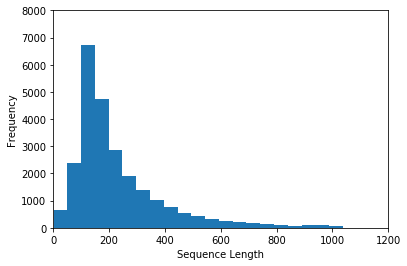

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(n_words, 50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axis([0, 1200, 0, 8000])
plt.show()

Looking at this, 250 words seems a good choice.

In [4]:
max_seq_len = 250

In [5]:
with open("max_seq_len.txt", "wb") as fp:
    pickle.dump(max_seq_len, fp)

## Mapping words to indexes

In this section we map words to indexes using our words_list variable.

**Question**: It is not entirely clear to me, how the unknown tokens are dealt with. From the code, a new token is assigned the index 399'999. But this corresponds to a word in the GloVe embedding data frame ("sandberger"). I guess that as this word is uncommun, it might serve the purpose of designating unknown words. Even stranger to me is the way padding is used: the author of the code I copied (https://www.oreilly.com/learning/perform-sentiment-analysis-with-lstms-using-tensorflow) uses 0 padding. But in our system, 0 corresponds to "the" and will be treated as a real word by the lstm.

First we do it for a specific file.

We display the content of the file (i.e. the real text).  (I commented out this part because it is useless for the real task)

In [22]:
#fname = pos_files_trn[3] #Can use any valid index (not just 3)
#with open(fname) as f:
#    for lines in f:
#        print(lines)
#        exit

Removes punctuation, parentheses, question marks, etc., and leaves only alphanumeric characters. In more details, as explained on this page:

https://www.regular-expressions.info/quickstart.html

`[A-Za-z0-9 ]` is a regular expression matching (once) any alphanumeric character or the space, `[^A-Za-z0-9 ]` matches (once) any character which is not one of those (because of the `^`), and `[^A-Za-z0-9 ]+`, matches the class of non-alphanumeric (or space) characters one or more times (because of the `+`). In the line

`re.sub(strip_special_chars, "", string.lower())`

this this expression is removed (replaced by `""`).

In [23]:
import re
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")

def clean_sentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

We map the given file to a list of indexes where each indexe corresponds to a word, according to the list `words_list`. (I commented out this part because it is useless for the real task)

In [24]:
#first_file = np.zeros((max_seq_len), dtype='int32')
#with open(fname) as f:
#    idx_counter = 0
#    line=f.readline()
#    cleaned_line = clean_sentences(line)
#    split = cleaned_line.split()
#    for word in split:
#        try:
#            first_file[idx_counter] = words_list.index(word)
#        except ValueError:
#            first_file[idx_counter] = 399999 #Vector for unknown words
#        idx_counter = idx_counter + 1
#first_file

### Training set

ids_train will be a matrix, which contains for each file of the training set (first the positive ones, then the negative ones) a row where the columns contain the indices corresponding to the words of the sample file.

The whole computation of the transformation of each text file into a list of indices takes time and needs to be performed only once. The result is saved after the first time and then reloaded for all the other executions.

In [25]:
#ids_train = np.zeros((n_files_trn, max_seq_len), dtype='int32')

In [26]:
#file_counter = 0
#for pf in pos_files_trn:
#    with open(pf, "r") as f:
#        idx_counter = 0
#        line=f.readline()
#        cleaned_line = clean_sentences(line)
#        split = cleaned_line.split()
#        for word in split:
#            try:
#                ids_train[file_counter][idx_counter] = words_list.index(word)
#            except ValueError:
#                ids_train[file_counter][idx_counter] = 399999 #Vector for unkown words
#            idx_counter = idx_counter + 1
#            if idx_counter >= max_seq_len:
#                break
#        file_counter = file_counter + 1

In [27]:
#for nf in neg_files_trn:
#    with open(nf, "r") as f:
#        idx_counter = 0
#        line=f.readline()
#        cleaned_line = clean_sentences(line)
#        split = cleaned_line.split()
#        for word in split:
#            try:
#                ids_train[file_counter][idx_counter] = words_list.index(word)
#            except ValueError:
#                ids_train[file_counter][idx_counter] = 399999 #Vector for unkown words
#            idx_counter = idx_counter + 1
#            if idx_counter >= max_seq_len:
#                break
#        file_counter = file_counter + 1 

In [28]:
#Pass into embedding function and see if it evaluates. 

#np.save('Saved_embeddings/idsMatrixTrain'+word_emb_size, ids_train)

ids_train = np.load('Saved_embeddings/idsMatrixTrain'+word_emb_size+'.npy')

### Testing set

In [29]:
#ids_test = np.zeros((n_files_test, max_seq_len), dtype='int32')

In [30]:
#file_counter = 0
#for pf in pos_files_test:
#    with open(pf, "r") as f:
#        idx_counter = 0
#        line=f.readline()
#        cleaned_line = clean_sentences(line)
#        split = cleaned_line.split()
#        for word in split:
#            try:
#                ids_test[file_counter][idx_counter] = words_list.index(word)
#            except ValueError:
#                ids_test[file_counter][idx_counter] = 399999 #Vector for unkown words
#            idx_counter = idx_counter + 1
#            if idx_counter >= max_seq_len:
#                break
#        file_counter = file_counter + 1

In [31]:
#for nf in neg_files_test:
#    with open(nf, "r") as f:
#        idx_counter = 0
#        line=f.readline()
#        cleaned_line = clean_sentences(line)
#        split = cleaned_line.split()
#        for word in split:
#            try:
#                ids_test[file_counter][idx_counter] = words_list.index(word)
#            except ValueError:
#                ids_test[file_counter][idx_counter] = 399999 #Vector for unkown words
#            idx_counter = idx_counter + 1
#            if idx_counter >= max_seq_len:
#                break
#        file_counter = file_counter + 1 

In [32]:
#np.save('Saved_embeddings/idsMatrixTest'+word_emb_size, ids_test)

ids_test = np.load('Saved_embeddings/idsMatrixTest'+word_emb_size+'.npy')

## Labels

Now we also create the **labels** with **one-hot-encoding** ([1, 0] for positive and [0, 1] for negative), as done in the original notebook.

In [34]:
len_pos_trn = len(pos_files_trn)
len_neg_trn = len(neg_files_trn)
y_train = [[1,0] for i in range(len_pos_trn)] + [[0,1] for i in range(len_neg_trn)]

In [35]:
len_pos_test = len(pos_files_test)
len_neg_test = len(neg_files_test)
y_test = [[1,0] for i in range(len_pos_test)] + [[0,1] for i in range(len_neg_test)]

In [36]:
len_trn = len_pos_trn + len_neg_trn
len_test = len_pos_test + len_neg_test

It seems that some premade estimators do not accept one-hot-encoding of the labels as explained here:https://stackoverflow.com/questions/48114258/tensorflow-estimator-number-of-classes-does-not-change

For this reason I create a function which converts a list containing one-hot-incoded labels into a list containing **ordinal encoded** labels.

In [37]:
def onehot_2_ordinal(onehot):
    n_classes = len(onehot[0])
    ordinal = []
    for i in range(len(onehot)):
        for j in range(n_classes):
            if onehot[i][j]==1:
                ordinal.append(j)
    return(ordinal)

In [38]:
y_train_ord = onehot_2_ordinal(y_train)
y_test_ord = onehot_2_ordinal(y_test)

We save it to access it from the other notebooks, following this Stack Overflow page: https://stackoverflow.com/questions/27745500/how-to-save-a-list-to-a-file-and-read-it-as-a-list-type#27745539

In [39]:
with open("y_train.txt", "wb") as fp:
    pickle.dump(y_train, fp)

In [40]:
with open("y_test.txt", "wb") as fp:
    pickle.dump(y_test, fp)

In [41]:
with open("y_train_ord.txt", "wb") as fp:
    pickle.dump(y_train_ord, fp)

In [42]:
with open("y_test_ord.txt", "wb") as fp:
    pickle.dump(y_test_ord, fp)